## **1. Problem Statement:**

---


Task 1:- Prepare a complete data analysis report on the given data.

Task 2:- Prediction of daily bike rental count based on the environmental and seasonal settings.


## **2. Importing Libraries:**

---



In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

#sklearn packages
#Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# stats packages
from scipy.stats import skew, kurtosis

## **3. Load the datasets**

---



In [50]:
# Load both datasets
hourly_data = pd.read_csv("hour.csv")
daily_data = pd.read_csv("day.csv")

- We have two csv files, The hour.csv file contains hourly data, while the day.csv file contains daily aggregated data.
- Here, we are analyzing the data at an hourly level, so we consider combining both the datasets, else we could have do modeling on a daily level, by directly using day.csv file.

---


## **4. Concatenating the two csv files**

---



In [52]:
# Drop 'hr' column from hourly_data before concatenating
brp = pd.concat([hourly_data.drop(columns=['hr']), daily_data], ignore_index=True)

# Display shapes
print("Hourly Data Shape:", hourly_data.shape)
print("Daily Data Shape:", daily_data.shape)
print("Combined Bike DataFrame Shape:", brp.shape)
brp

Hourly Data Shape: (17379, 17)
Daily Data Shape: (731, 16)
Combined Bike DataFrame Shape: (18110, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,1,0.240000,0.287900,0.810000,0.000000,3,13,16
1,2,2011-01-01,1,0,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,8,32,40
2,3,2011-01-01,1,0,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,5,27,32
3,4,2011-01-01,1,0,1,0,6,0,1,0.240000,0.287900,0.750000,0.000000,3,10,13
4,5,2011-01-01,1,0,1,0,6,0,1,0.240000,0.287900,0.750000,0.000000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18105,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
18106,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
18107,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
18108,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


- Our task is to predict daily bike rental counts, and the 'hr' column represents the hourly information, it would be appropriate to drop the 'hr' column during concatenation. The hourly information is not relevant for predicting daily counts, and including it could introduce noise or unnecessary complexity into our model.`

---



## **5. Domain Analysis**

---



#### Here's an analysis of the columns in our concatenated dataset:

- instant: Record index; This seems to be a unique identifier for each record. It may not carry much predictive power and can be dropped during modeling.
- dteday: Date; This column represents the date of the records. Ensure it's in datetime format. Extracting features like day, month, and year from this could be helpful.
- season: Season (1:winter, 2:spring, 3:summer, 4:fall); indicates the season during which the record was made. Understand how bike rentals vary across seasons.
- yr: Year (0: 2011, 1:2012); indicates the year. Let's check if there are any trends or differences between the years.
- mnth: Month (1 to 12); Represents the month of the record. Understand if there are monthly patterns in bike rentals.
- hr: Hour (0 to 23); indicates the hour of the record. Explore hourly patterns in bike rentals.
- holiday: Weather day is a holiday or not. Check if there are variations in bike rentals on holidays.
- weekday: Day of the week. Understand if bike rentals differ on weekdays.
- workingday: If neither a weekend nor holiday, it is 1; otherwise, 0. Explore how working days impact bike rentals.
- weathersit: Weather situation. Understand how different weather situations affect bike rentals.
- temp: Normalized temperature in Celsius. Check for correlations between temperature and bike rentals.
- atemp: Normalized feeling temperature in Celsius. Similar to 'temp', check for correlations.
- hum: Normalized humidity. Explore how humidity levels impact bike rentals.
- windspeed: Normalized wind speed. Check if wind speed has any correlation with bike rentals.
- casual: Count of casual users. Understand the contribution of casual users to total bike rentals.
- registered: Count of registered users. Understand the contribution of registered users to total bike rentals.
- cnt: Count of total rental bikes including both casual and registered. This is our target variable. Understand the overall distribution and variation.


## **6. Basic Checks**

---


In [4]:
# Understanding the basic structure of the data
print(brp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     18110 non-null  int64  
 1   dteday      18110 non-null  object 
 2   season      18110 non-null  int64  
 3   yr          18110 non-null  int64  
 4   mnth        18110 non-null  int64  
 5   holiday     18110 non-null  int64  
 6   weekday     18110 non-null  int64  
 7   workingday  18110 non-null  int64  
 8   weathersit  18110 non-null  int64  
 9   temp        18110 non-null  float64
 10  atemp       18110 non-null  float64
 11  hum         18110 non-null  float64
 12  windspeed   18110 non-null  float64
 13  casual      18110 non-null  int64  
 14  registered  18110 non-null  int64  
 15  cnt         18110 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.2+ MB
None


### <u>Insights:</u>
- Data Types: int64: Integer data type. float64: Floating-point (decimal) data type. object: Typically represents categorical or text data.
- Missing Values: The dataset contains 18110 entries, and most columns have non-null values. Column 'hr' has some missing values (non-null count is less than the total number of entries).
- Columns: instant: Record index. It's an integer, no missing values.
- dteday: Date. It's an object (string). No missing values.
- season, yr, mnth, hr, holiday, weekday, workingday, weathersit: Integer columns with no missing values.
- temp, atemp, hum, windspeed: Float columns with no missing values.
- casual, registered, cnt: Integer columns with no missing values.
- Memory Usage: The DataFrame consumes approximately 2.3+ MB of memory.

---



In [5]:
# Display summary statistics
brp.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,18110.0,8354.006405,5180.771860,1.00,3797.2500,8324.500000,12851.7500,17379.0000
season,18110.0,2.501436,1.107045,1.00,2.0000,3.000000,3.0000,4.0000
yr,18110.0,0.502485,0.500008,0.00,0.0000,1.000000,1.0000,1.0000
mnth,18110.0,6.537051,3.439213,1.00,4.0000,7.000000,10.0000,12.0000
holiday,18110.0,0.028769,0.167160,0.00,0.0000,0.000000,0.0000,1.0000
weekday,18110.0,3.003424,2.005677,0.00,1.0000,3.000000,5.0000,6.0000
workingday,18110.0,0.682772,0.465410,0.00,0.0000,1.000000,1.0000,1.0000
weathersit,18110.0,1.424075,0.635830,1.00,1.0000,1.000000,2.0000,4.0000
temp,18110.0,0.496922,0.192177,0.02,0.3400,0.500000,0.6600,1.0000
atemp,18110.0,0.475718,0.171496,0.00,0.3333,0.484800,0.6212,1.0000


In [6]:
# check their rows and columns:
brp.shape

(18110, 16)

- There are 18,110 rows and 17 columns/ features in our dataset.

---



In [7]:
# Explore the first few rows of the dataset to understand the structure.
brp.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
brp.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
18105,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
18106,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
18107,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
18108,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
18109,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [9]:
brp.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
4812,4813,2011-07-24,3,0,7,0,0,0,1,0.86,0.8182,0.50,0.3284,61,165,226
13114,13115,2012-07-05,3,1,7,0,4,1,1,0.92,0.8333,0.33,0.3582,71,183,254
16058,16059,2012-11-06,4,1,11,0,2,1,1,0.30,0.2879,0.56,0.2239,15,356,371
16890,16891,2012-12-11,4,1,12,0,2,1,2,0.38,0.3939,0.50,0.2239,28,226,254
777,778,2011-02-04,1,0,2,0,5,1,2,0.24,0.2424,0.65,0.1642,2,69,71


## **7. Data Preprocessing and cleaning**

---



### **7.1 Dropping irrelevant columns**

---



In [53]:
brp.drop(columns=['instant'], inplace=True)
brp

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,6,0,1,0.240000,0.287900,0.810000,0.000000,3,13,16
1,2011-01-01,1,0,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,8,32,40
2,2011-01-01,1,0,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,5,27,32
3,2011-01-01,1,0,1,0,6,0,1,0.240000,0.287900,0.750000,0.000000,3,10,13
4,2011-01-01,1,0,1,0,6,0,1,0.240000,0.287900,0.750000,0.000000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18105,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
18106,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
18107,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
18108,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


### 7.2 Date Parsing and Indexing:
- Converting the 'dteday' column to a datetime format and setting it as the index.

---



In [54]:
# Here 'brp' is our DataFrame
brp['dteday'] = pd.to_datetime(brp['dteday'])  # Convert to datetime format
brp.set_index('dteday', inplace=True)  # Set 'dteday' as the index

### 7.3 Checking for missing values

---



In [6]:
brp.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
brp.sample(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,
2011-09-09,3,0,9,0,5,1,1,0.66,0.5909,0.89,0.1642,33,316,349
2011-04-12,2,0,4,0,2,1,3,0.46,0.4545,0.94,0.4925,4,50,54
2012-07-20,3,1,7,0,5,1,2,0.66,0.5909,0.89,0.1642,3,6,9
2012-04-19,2,1,4,0,4,1,1,0.58,0.5455,0.43,0.0000,54,183,237
2012-10-10,4,1,10,0,3,1,1,0.46,0.4545,0.82,0.1045,9,498,507


In [8]:
brp.shape

(18110, 14)

In [9]:
brp.duplicated().sum()

26

- If the duplicated rows are a very small fraction in our dataset and their presence doesn't significantly impact our analysis, we can choose to keep them.

---



#### skipping outlier handling in time series model due to the mentioned reason:
- Let me consider the impact of outliers on our analysis objectives. Outliers can influence statistical measures, such as means and variances, and can distort model fitting and parameter estimation. In some cases, outliers may be influential observations that provide valuable insights into the data.
#### also skipping scaling technique for time series as:
- Scaling is generally more crucial for machine learning models, particularly those that rely on distance metrics, such as k-Nearest Neighbors or Support Vector Machines. For time series forecasting models like ARIMA or SARIMA, scaling might not be as critical, as these models are based on differencing and autoregressive components.
---



In [10]:
unique_values= brp.nunique()
print("Number of unique values in each column: ")
print(unique_values)

Number of unique values in each column: 
season           4
yr               2
mnth            12
holiday          2
weekday          7
workingday       2
weathersit       4
temp           528
atemp          752
hum            651
windspeed      679
casual         783
registered    1440
cnt           1552
dtype: int64


In [11]:
for column in brp.columns:
    unique_values = brp[column].unique()
    print(f"Unique values in the '{column}' column:")
    print(unique_values)
    print()

Unique values in the 'season' column:
[1 2 3 4]

Unique values in the 'yr' column:
[0 1]

Unique values in the 'mnth' column:
[ 1  2  3  4  5  6  7  8  9 10 11 12]

Unique values in the 'holiday' column:
[0 1]

Unique values in the 'weekday' column:
[6 0 1 2 3 4 5]

Unique values in the 'workingday' column:
[0 1]

Unique values in the 'weathersit' column:
[1 2 3 4]

Unique values in the 'temp' column:
[0.24      0.22      0.2       0.32      0.38      0.36      0.42
 0.46      0.44      0.4       0.34      0.3       0.26      0.16
 0.14      0.18      0.12      0.28      0.1       0.08      0.06
 0.04      0.02      0.52      0.56      0.58      0.6       0.48
 0.54      0.5       0.66      0.64      0.62      0.68      0.7
 0.74      0.76      0.72      0.78      0.82      0.8       0.86
 0.88      0.9       0.84      0.92      0.94      0.96      0.98
 1.        0.344167  0.363478  0.196364  0.226957  0.204348  0.196522
 0.165     0.138333  0.150833  0.169091  0.172727  0.16087   0.2

## 8. Exploratory Data Analysis(EDA)

---



### 8.1 Univariate/ Bivariate Analysis

---



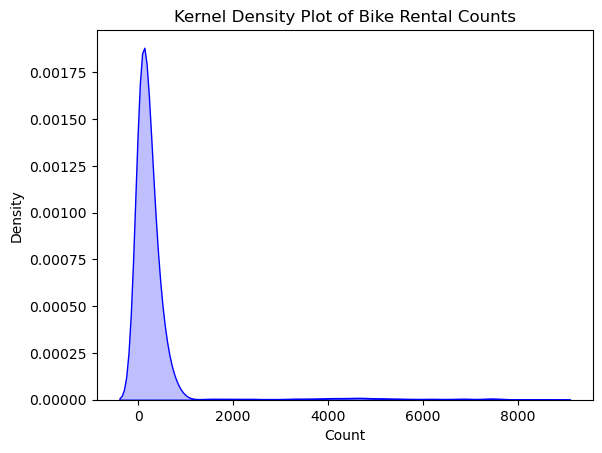

In [12]:
# Exploring the distribution of the target variable 'cnt' using plots.
sns.kdeplot(brp['cnt'], fill=True, color='blue')
plt.title('Kernel Density Plot of Bike Rental Counts')
plt.xlabel('Count')
plt.ylabel('Density')
plt.show()

### <u>Insights:</u>
- Significant positive skewness, seems a right-skewed distribution with a long tail on the right side. This means that there are some very high values in the 'cnt' column.
- This distribution indicates the frequency of different bike rental counts in the dataset. For instance,the most common count appears to be 5, followed by 6, 4, and 3.

---

### 8.1 (a)'season': Exploring the distribution of bike rentals across different seasons.

---



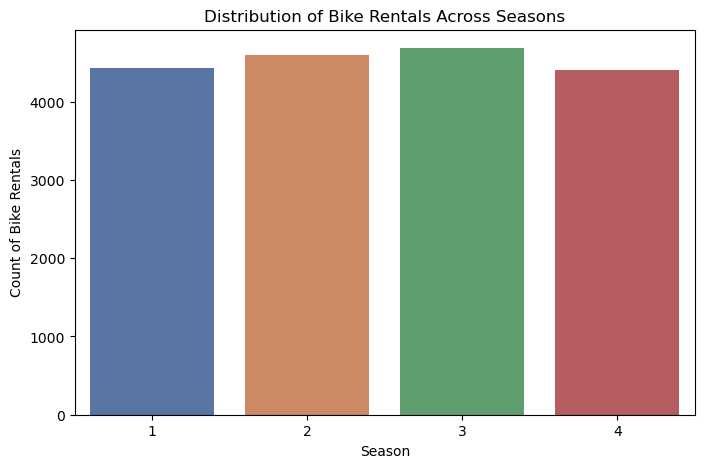

In [13]:
# Define the color palette
palette = sns.color_palette("deep")  # You can choose any other palette you prefer

# Bar plot for 'season'
plt.figure(figsize=(8, 5))
sns.countplot(x='season', data=brp, palette=palette)
plt.title('Distribution of Bike Rentals Across Seasons')
plt.xlabel('Season')
plt.ylabel('Count of Bike Rentals')
plt.show()

### <u>Insights:</u>
- All seasons have an equal count of bike rentals.
- The majority of bike rentals occur during the summer, followed by spring, winter, and fall.
---



### 8.1(b) 'yr': Analyzing the bike rental patterns for each year (2011 and 2012).

---



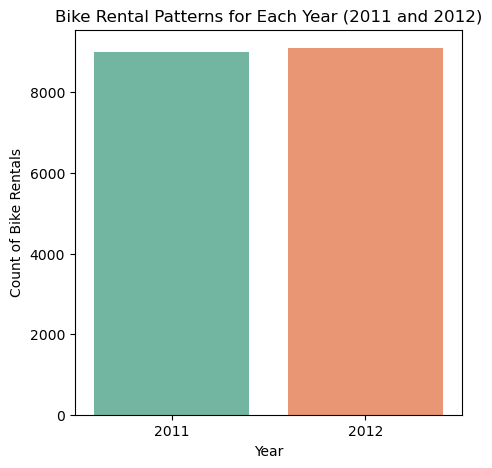

In [14]:
# Define the color palette
palette = sns.color_palette("Set2")  # You can choose any other palette you prefer

# Bar plot for 'yr' with specified color palette
plt.figure(figsize=(5, 5))
sns.countplot(x='yr', data=brp, palette=palette)
plt.title('Bike Rental Patterns for Each Year (2011 and 2012)')
plt.xlabel('Year')
plt.ylabel('Count of Bike Rentals')
plt.xticks([0, 1], ['2011', '2012'])  # Set x-axis labels
plt.show()

### <u>Insights:</u>
- The distribution of bike rentals in both years is almost equal.
- However, in 2012, there were relatively more bike rentals.
---



### 8.1(c) 'mnth': Checking the distribution of rentals across different months.

---



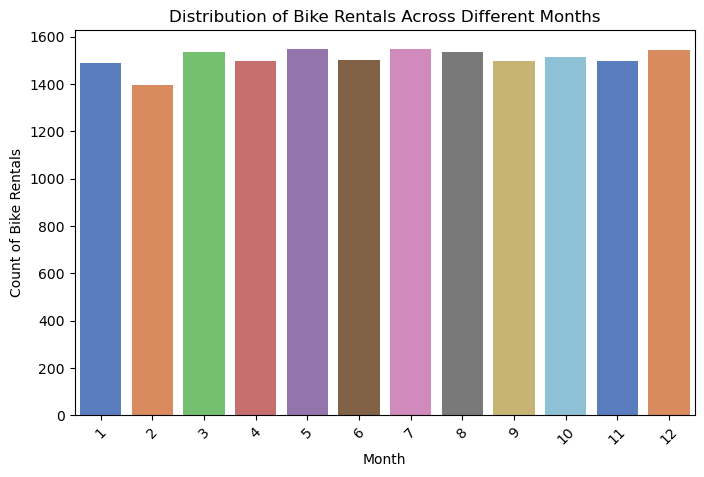

In [15]:
# Define the color palette
palette = sns.color_palette("muted")  # You can choose any other palette you prefer

# Bar plot for 'mnth'
plt.figure(figsize=(8, 5))
sns.countplot(x='mnth', data=brp, palette=palette)
plt.title('Distribution of Bike Rentals Across Different Months')
plt.xlabel('Month')
plt.ylabel('Count of Bike Rentals')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

### Insights:
- Most of the bikes been rented on the month of december, followed with august, may and march.

---



### 8.1(d) 'holiday': Understanding the impact of holidays on bike rentals.

---



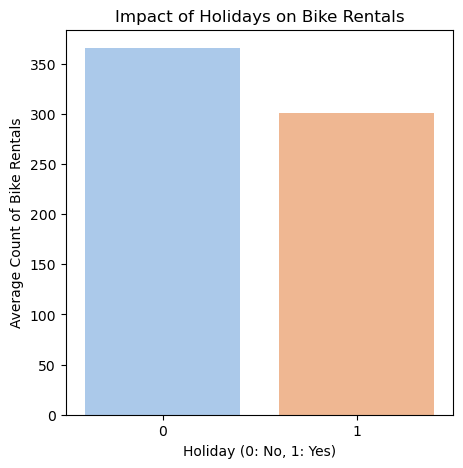

In [16]:
# Define the color palette
palette = sns.color_palette("pastel")  # You can choose any other palette you prefer

# Bar plot for 'holiday'
plt.figure(figsize=(5, 5))
sns.barplot(x='holiday', y='cnt', data=brp, ci=None,palette=palette)
plt.title('Impact of Holidays on Bike Rentals')
plt.xlabel('Holiday (0: No, 1: Yes)')
plt.ylabel('Average Count of Bike Rentals')
plt.show()

### Insights:
- This conclusion suggests that bike rentals are more common on weekdays.

---



### 8.1(e) 'weekday': Analyzing the bike rentals based on different days of the week.

---



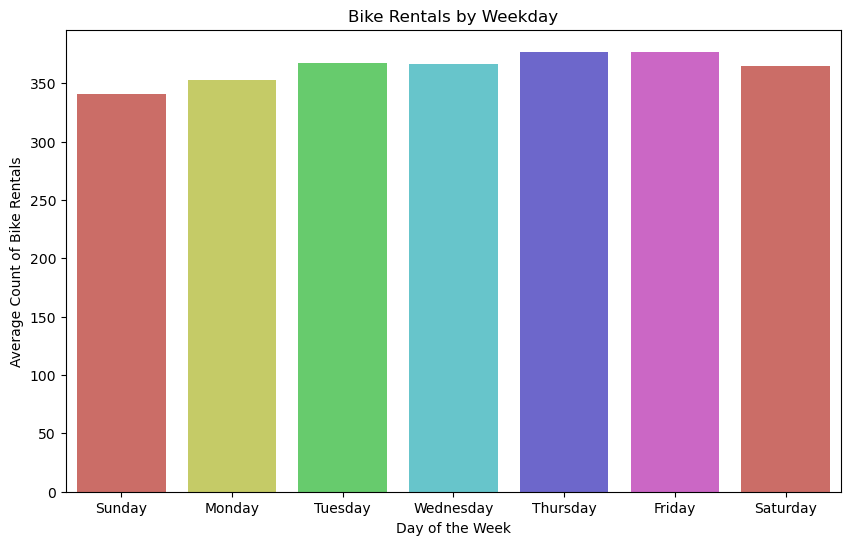

In [17]:
# Define the color palette
palette = sns.color_palette("hls")  # You can choose any other palette you prefer

# Bar plot for 'weekday'
plt.figure(figsize=(10, 6))
sns.barplot(x='weekday', y='cnt', data=brp, ci=None,palette=palette)
plt.title('Bike Rentals by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Average Count of Bike Rentals')
plt.xticks(ticks=range(7), labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

### Insights:
- Most of the bikes are rented on Thursday and Friday, followed by Tuesday, Wednesday, and Saturday.

---



### 8.1(f) 'workingday': Exploring bike rental patterns on working days

---



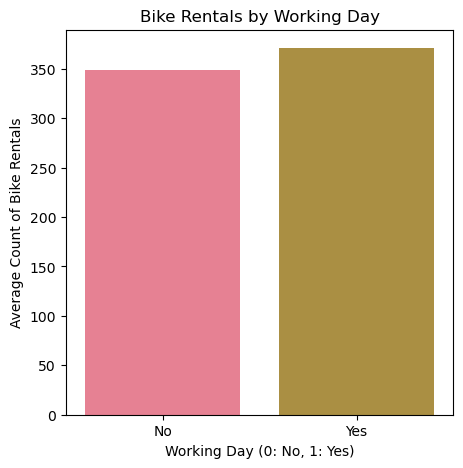

In [18]:
# Define the color palette
palette = sns.color_palette("husl")  # You can choose any other palette you prefer

# Bar plot for 'workingday'
plt.figure(figsize=(5, 5))
sns.barplot(x='workingday', y='cnt', data=brp, ci=None, palette=palette)
plt.title('Bike Rentals by Working Day')
plt.xlabel('Working Day (0: No, 1: Yes)')
plt.ylabel('Average Count of Bike Rentals')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

### Insights:
- Most bike rentals occur on weekdays

---



### 8.1(g) 'weathersit': Examine the distribution of rentals based on weather conditions.

---



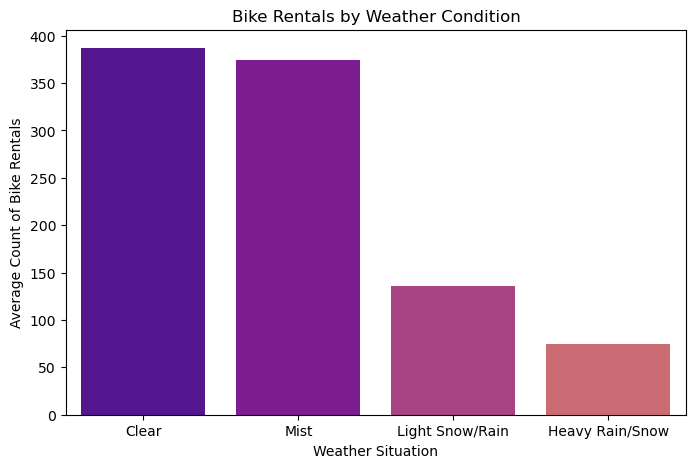

In [19]:
# Define the color palette
palette = sns.color_palette("plasma")  # You can choose any other palette you prefer


# Bar plot for 'weathersit'
plt.figure(figsize=(8, 5))
sns.barplot(x='weathersit', y='cnt', data=brp, ci=None, palette=palette)
plt.title('Bike Rentals by Weather Condition')
plt.xlabel('Weather Situation')
plt.ylabel('Average Count of Bike Rentals')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Clear', 'Mist', 'Light Snow/Rain', 'Heavy Rain/Snow'])
plt.show()

### Insights:
- Most of the bikes are rented during clear weather, followed by misty weather.

---



### 8.1(h) 'temp' and 'atemp': Investigate the normalized temperature and feeling temperature distributions.

---



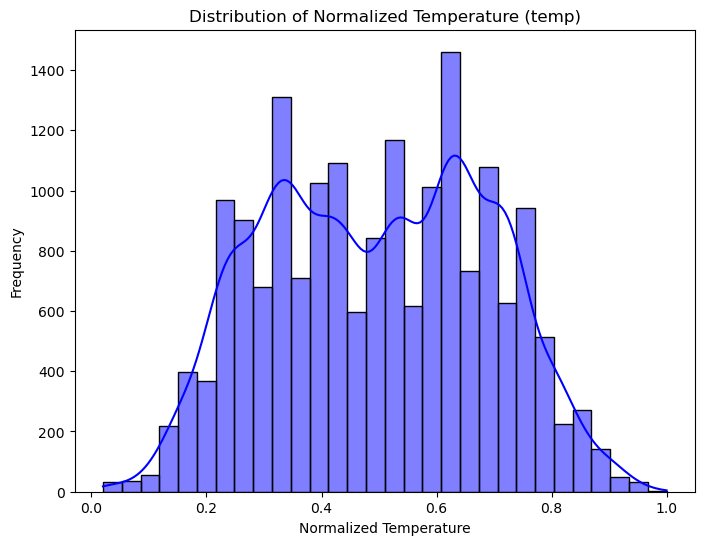

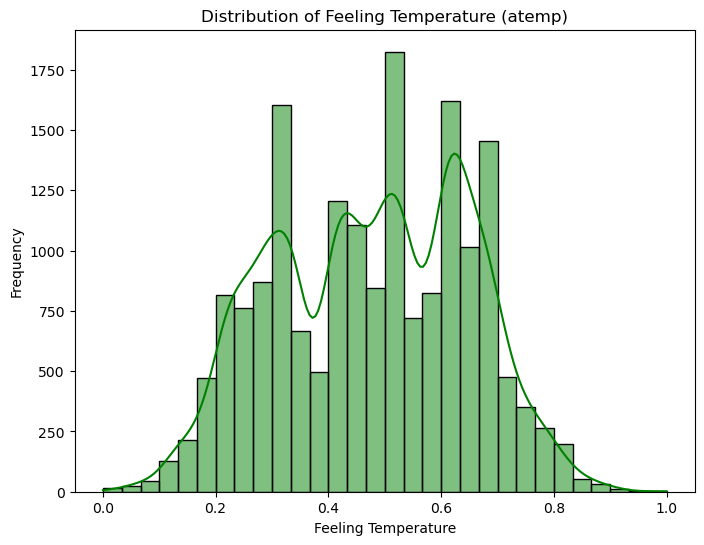

In [20]:
# Histogram for 'temp'
plt.figure(figsize=(8, 6))
sns.histplot(data=brp, x='temp', bins=30, kde=True, color='blue')
plt.title('Distribution of Normalized Temperature (temp)')
plt.xlabel('Normalized Temperature')
plt.ylabel('Frequency')
plt.show()

# Histogram for 'atemp'
plt.figure(figsize=(8, 6))
sns.histplot(data=brp, x='atemp', bins=30, kde=True, color='green')
plt.title('Distribution of Feeling Temperature (atemp)')
plt.xlabel('Feeling Temperature')
plt.ylabel('Frequency')
plt.show()

### Insights:
- Normalized temp being the distribution of temperature data is fairly symmetric.
- Feeling temperature distribution is slightly skewed to the left but overall it indicates a nearly symmetric distribution with a slight tendency towards the left.

### 8.1(i) 'hum': Checking the distribution of humidity values.

---



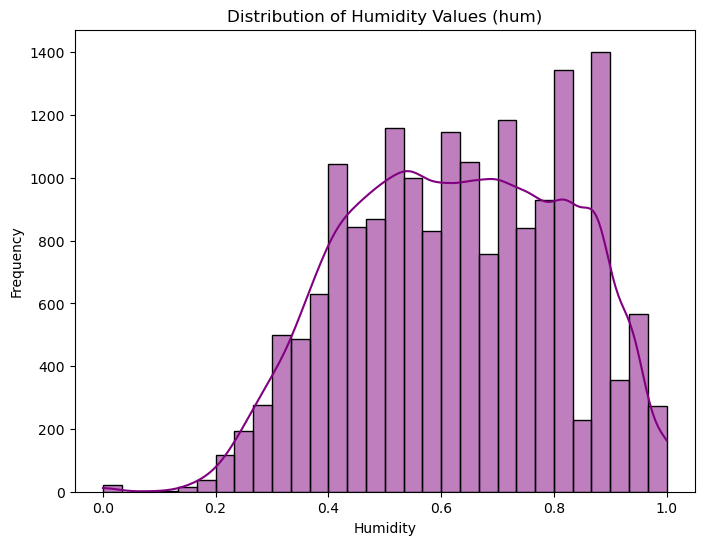

In [21]:
# Histogram for 'hum'
plt.figure(figsize=(8, 6))
sns.histplot(data=brp, x='hum', bins=30, kde=True, color='purple')
plt.title('Distribution of Humidity Values (hum)')
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.show()

### Insights:
- Negative skewness could mean that there are more instances of higher humidity values relative to lower humidity values, with a few instances of extremely low humidity pulling the distribution to the left. However, it seems that the skewness is relatively small, indicating a distribution that is only slightly skewed to the left.

### 8.1 (j) 'windspeed': Exploring the distribution of wind speed

---



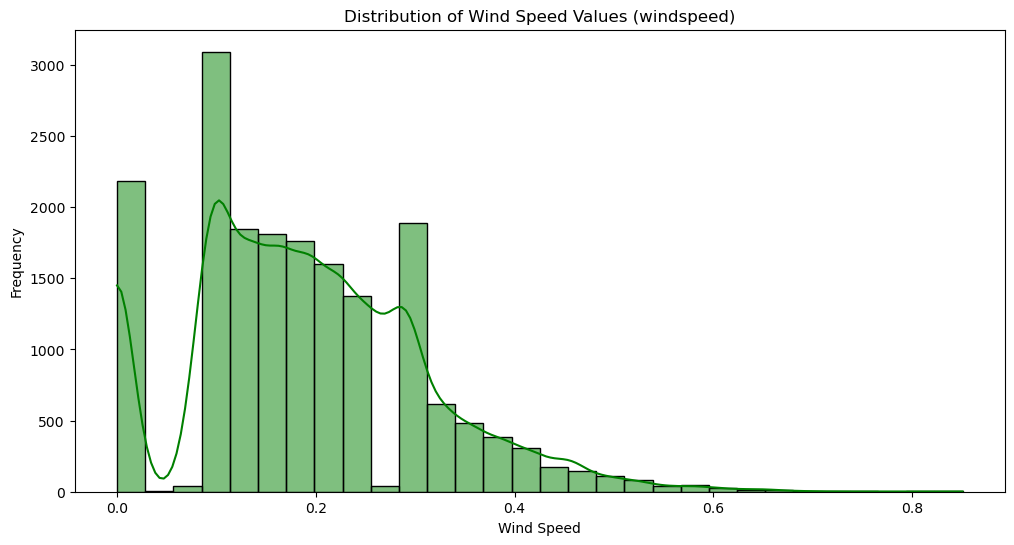

In [22]:
# Histogram for 'windspeed'
plt.figure(figsize=(12, 6))
sns.histplot(data=brp, x='windspeed', bins=30, kde=True, color='green')
plt.title('Distribution of Wind Speed Values (windspeed)')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

### Insights:
- In the context of windspeed, a positive skewness could mean that there are more instances of lower windspeed values relative to higher windspeed values, with a few instances of extremely high windspeed pulling the distribution to the right.

## 8.2 Multivariate Analysis

---



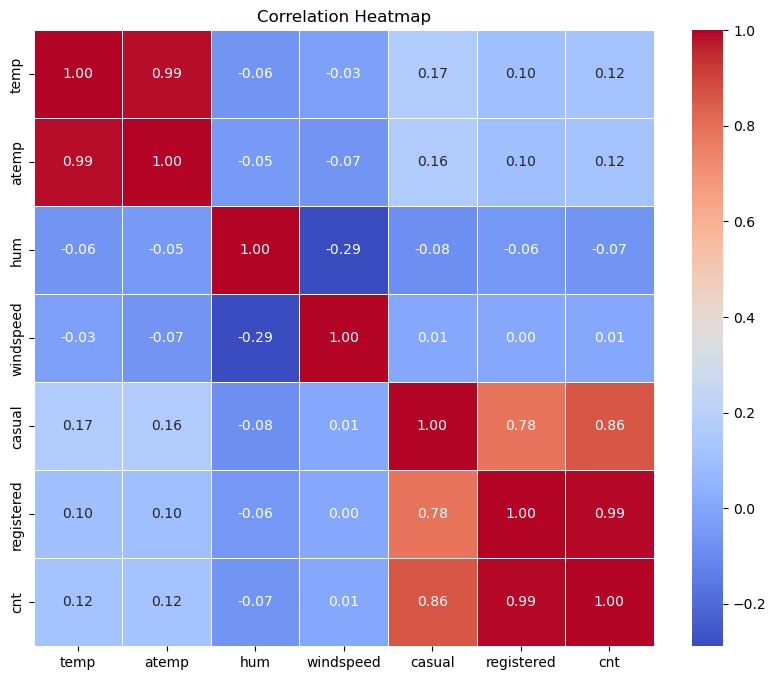

In [23]:
# Select relevant columns for correlation
correlation_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

# Create a correlation matrix
correlation_matrix = brp[correlation_columns].corr()

# Create a correlation matrix
correlation_matrix = brp[correlation_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Insights:
- temp and atemp have a very high positive correlation of approximately 0.988, indicating that they are highly correlated. This is expected since both variables represent temperature measures.
- Humidity has a weak negative correlation with temp and atemp, which is around -0.064 and -0.046, respectively. This suggests that as temperature increases, humidity tends to decrease slightly.
- Windspeed has a weak positive correlation with temp and atemp, which is negligible (-0.026 and -0.065, respectively).
- Casual and registered users have a strong positive correlation of approximately 0.784, indicating that the number of casual users tends to increase with the number of registered users.
- The count (cnt) shows a strong positive correlation with casual users (0.864) and registered users (0.990). This indicates that the total count of bike rentals is highly correlated with both casual and registered users.
- Positive correlation values indicate a positive relationship between variables. Negative correlation values indicate a negative relationship between variables. Values close to 1 or -1 indicate a strong correlation.
##### Point to be noted: Correlation does not imply causation. It only measures the linear relationship between two variables. Also, will consider checking for multicollinearity, especially if we are planning to use these variables in predictive modeling, moving further.
- A heatmap where the color intensity represents the strength and direction of the correlation. Positive correlations will be displayed in warmer colors, while negative correlations will be in cooler colors.
---



## 8.3 **Time-Series Visualization**
---
- Visualize the total rentals over time to identify trends and patterns.

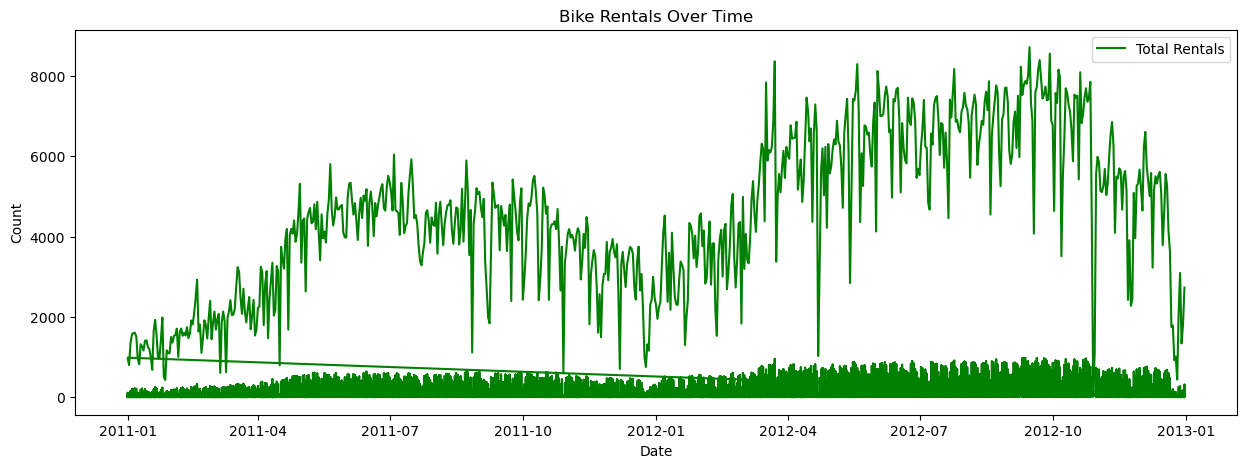

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(brp.index, brp['cnt'], label='Total Rentals', color='green')
plt.title('Bike Rentals Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

### 8.3(a) Seasonal Trends

---



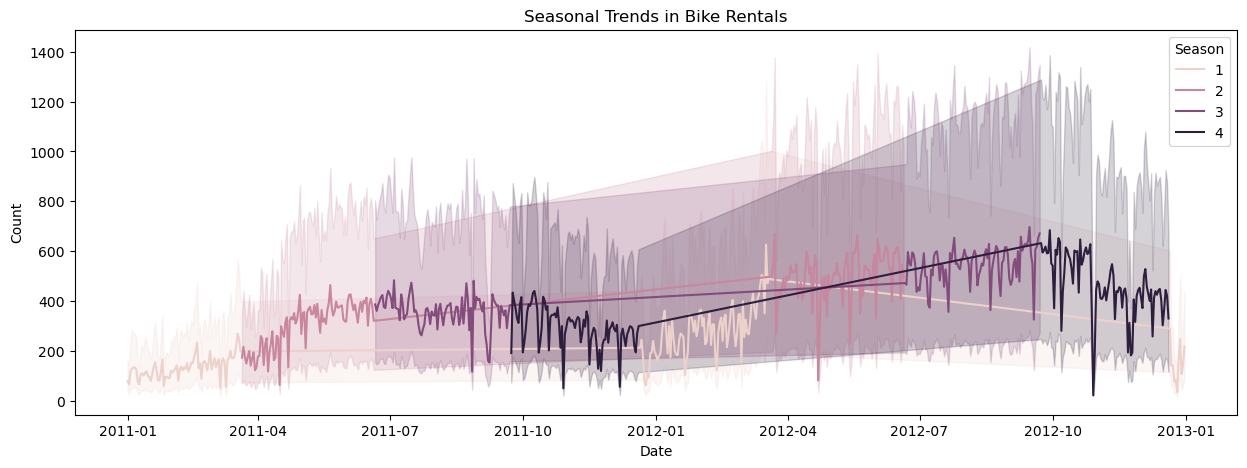

In [25]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=brp, x=brp.index, y='cnt', hue='season')
plt.title('Seasonal Trends in Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Season')
plt.show()

### 8.3(b) Working day vs. Non Working day

---



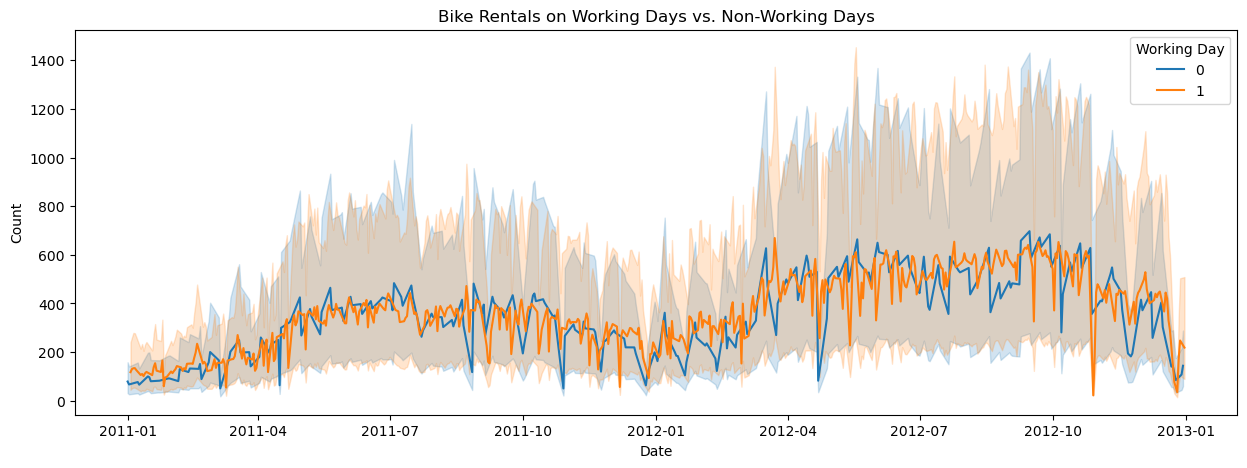

In [26]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=brp, x=brp.index, y='cnt', hue='workingday')
plt.title('Bike Rentals on Working Days vs. Non-Working Days')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Working Day')
plt.show()

### 8.3 (c) Weather Impact

---



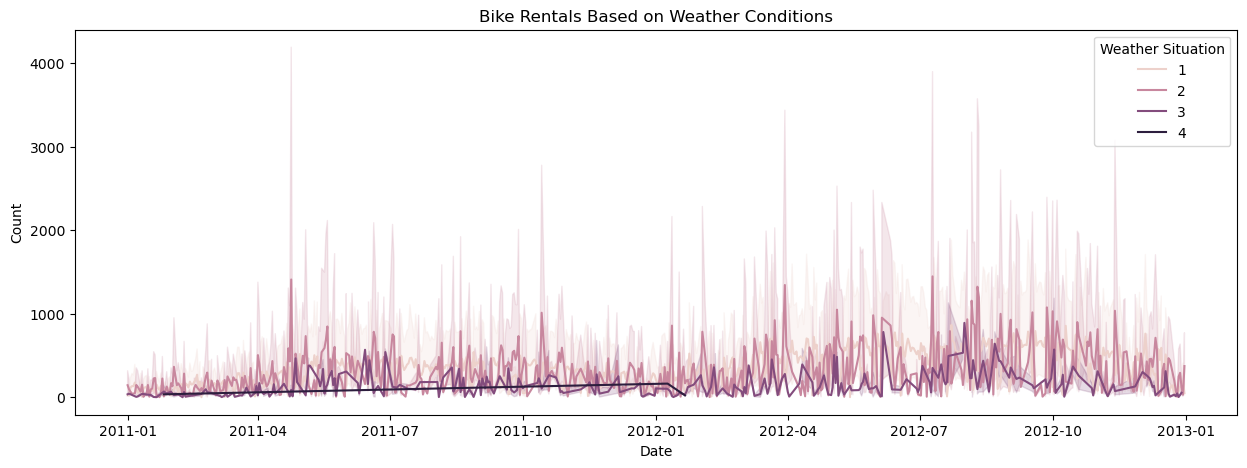

In [27]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=brp, x=brp.index, y='cnt', hue='weathersit')
plt.title('Bike Rentals Based on Weather Conditions')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Weather Situation')
plt.show()

### 8.3(d) Let's Decompose the time series into trend, seasonality, and residual components to better understand the underlying patterns.

---



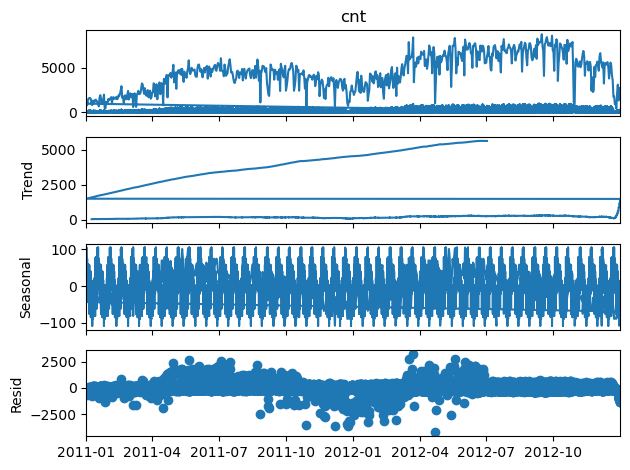

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonality, and residual components
result = seasonal_decompose(brp['cnt'], model='additive', period=365)  # Assuming annual seasonality

# Plot the decomposition
result.plot()
plt.show()

## 9. <u>**Check for stationarity**</u>
- Regarding stationarity, it is a crucial consideration for time series models, especially traditional ones like ARIMA. Stationarity ensures that the statistical properties of a time series, such as mean and variance, remain constant over time. If your time series is not stationary, it can lead to inaccurate model predictions.
- Conducting a test for stationarity (e.g., Augmented Dickey-Fuller test) on our time series data. If the p-value is above a certain significance level (e.g., 0.05), we can conclude that the time series is not stationary.
- Transform to Achieve Stationarity: If our time series is not stationary, consider applying transformations like differencing to make it stationary. This involves subtracting the previous value from the current one.

---



In [55]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'cnt' is your time series column
result = adfuller(brp['cnt'])

# Extract and print the results
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Check for stationarity based on p-value
if p_value <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -2.8070544594444566
p-value: 0.057273132978537936
The time series is not stationary.


### 9.1 Perform differencing to make it stationary

In [56]:
# Assuming 'cnt' is your time series column
brp['cnt_diff'] = brp['cnt'].diff()

# Drop missing values introduced by differencing
brp.dropna(inplace=True)

# Check stationarity of the differenced series
result_diff = adfuller(brp['cnt_diff'])

# Extract and print the results
adf_statistic_diff = result_diff[0]
p_value_diff = result_diff[1]

print(f'ADF Statistic (after differencing): {adf_statistic_diff}')
print(f'p-value (after differencing): {p_value_diff}')

# Check for stationarity based on p-value
if p_value_diff <= 0.05:
    print("The differenced time series is stationary.")
else:
    print("The differenced time series is not stationary.")

ADF Statistic (after differencing): -19.280448363826252
p-value (after differencing): 0.0
The differenced time series is stationary.


### 9.2 **ACF Plot**

---



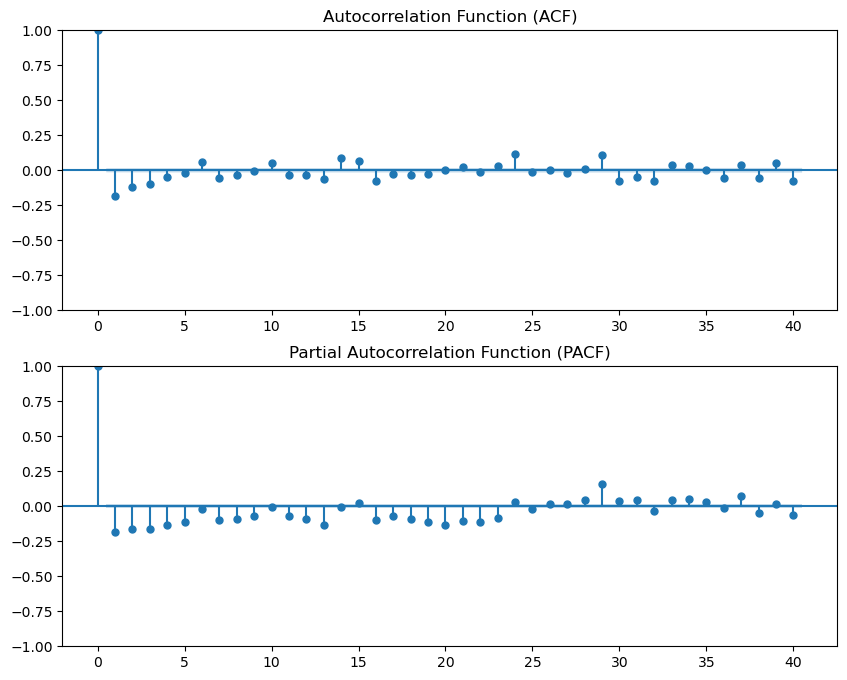

In [31]:
# Assuming 'cnt_diff' is your differenced time series column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(brp['cnt_diff'], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(brp['cnt_diff'], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

### 9.3 Statistical Tests:
- Performing statistical tests for seasonality, such as the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. This test provide formal statistical evidence of seasonality.

In [57]:
from statsmodels.tsa.stattools import kpss

# Assuming 'cnt_x' is your time series column
kpss_stat, p_value, lags, critical_values = kpss(brp['cnt'])

print('kpss_stat:', kpss_stat)
print(' p_value:',  p_value)
print('lags:', lags)
print('critical values:',critical_values )

kpss_stat: 3.2895962838986748
 p_value: 0.01
lags: 78
critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


- A significant p-value indicates the presence of seasonality.

- By combining visual inspection and statistical methods, we gain insights into whether our time series exhibits seasonality and how strong it is.
- So, we will use time series models that inherently account for seasonality, such as SARIMA (Seasonal AutoRegressive Integrated Moving Average). These models can automatically handle seasonality during the fitting process.

## 10. Train-test Split
- In time series modeling, a traditional random train-test split like those used in standard machine learning tasks is not appropriate. This is because the temporal ordering of data points is crucial in time series analysis.

- Instead, we typically perform a sequential train-test split where we train the model on data up to a certain point in time and then evaluate its performance on data from a later time period. This reflects the real-world scenario where we train the model on historical data and then use it to make predictions on future data.

---



In [58]:
# Sort the data by date (if not already sorted)
brp.sort_index(inplace=True)

# Define the cutoff date
cutoff_date = '2012-01-01'  # Adjust this date based on your requirement

# Split the data into training and testing sets
train_data = brp[brp.index < cutoff_date]
test_data = brp[brp.index >= cutoff_date]

# Display the shapes of training and testing sets
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)

Training Data Shape: (9009, 15)
Testing Data Shape: (9100, 15)


### 11. Extracting cnt_diff column for ARIMA & SARIMA(time-series model)

In [16]:
# Extract 'cnt_diff' column from training set
train_cnt_diff = train_data['cnt_diff']

# Extract 'cnt_diff' column from testing set
test_cnt_diff = test_data['cnt_diff']

# Display the shapes of the extracted series
print("Training 'cnt_diff' Shape:", train_cnt_diff.shape)
print("Testing 'cnt_diff' Shape:", test_cnt_diff.shape)

Training 'cnt_diff' Shape: (9009,)
Testing 'cnt_diff' Shape: (9100,)


In [59]:
train_cnt_diff

dteday
2011-01-01    24.0
2011-01-01    11.0
2011-01-01    -6.0
2011-01-01    -2.0
2011-01-01    -1.0
              ... 
2011-12-31    41.0
2011-12-31    38.0
2011-12-31    89.0
2011-12-31    56.0
2011-12-31    40.0
Name: cnt_diff, Length: 9009, dtype: float64

### 12. Selecting best combinations of p,d,q value.

---



In [18]:
import itertools
p=d=q= range(0,10) # values of p,d,q range from 0 to 10
pdq= list(itertools.product(p,d,q))
# this is used to find the cartesian product from the given iterator, output is lexicographic order.
pdq #number of combination of pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 2, 9),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 3, 9),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 5),
 (0, 4, 6),
 (0, 4, 7),
 (0, 4, 8),
 (0, 4, 9),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 5),
 (0, 5, 6),
 (0, 5, 7),
 (0, 5, 8),
 (0, 5, 9),
 (0, 6, 0),
 (0, 6, 1),
 (0, 6, 2),
 (0, 6, 3),
 (0, 6, 4),
 (0, 6, 5),
 (0, 6, 6),
 (0, 6, 7),
 (0, 6, 8),
 (0, 6, 9),
 (0, 7, 0),
 (0, 7, 1),
 (0, 7, 2),
 (0, 7, 3),
 (0, 7, 4),
 (0, 7, 5),
 (0, 7, 6),
 (0, 7, 7),
 (0, 7, 8),
 (0, 7, 9),
 (0, 8, 0),
 (0, 8, 1),
 (0, 8, 2),
 (0,

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
list1 = []
list2 = []

for params in pdq:
    try:
        model = ARIMA(train_data['cnt_diff'], order=params)
        model_arima = model.fit()
        print(params, model_arima.aic)
        list1.append(params)
        list2.append(model_arima.aic)
    except Exception as e:
        print(f"Error for {params}: {e}")
        continue

## 13. **ARIMA Model**

---



In [60]:
# Remove duplicate datetime values
train_data = train_data[~train_data.index.duplicated(keep='first')]

# Resample the data to daily frequency and forward-fill missing values
train_data = train_data.resample('D').ffill()

- This code will first remove the duplicated datetime values, keeping only the first occurrence of each unique datetime. Then, it will resample the data to a daily frequency and forward-fill any missing values.

---



In [61]:
# Create date index with daily frequency
dates = pd.date_range('2011-01-01', periods=100, freq='D')

data = pd.DataFrame({'value':range(100)}, index=dates)

model = ARIMA(data)
model_fit = model.fit()

                               SARIMAX Results                                
Dep. Variable:               cnt_diff   No. Observations:                 9009
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -59821.792
Date:                Sun, 04 Feb 2024   AIC                         119653.585
Time:                        07:58:10   BIC                         119689.114
Sample:                             0   HQIC                        119665.674
                               - 9009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9834      0.041    -24.043      0.000      -1.064      -0.903
ar.L2          0.0162      0.022      0.720      0.472      -0.028       0.060
ma.L1         -0.0005      0.032     -0.014      0.9

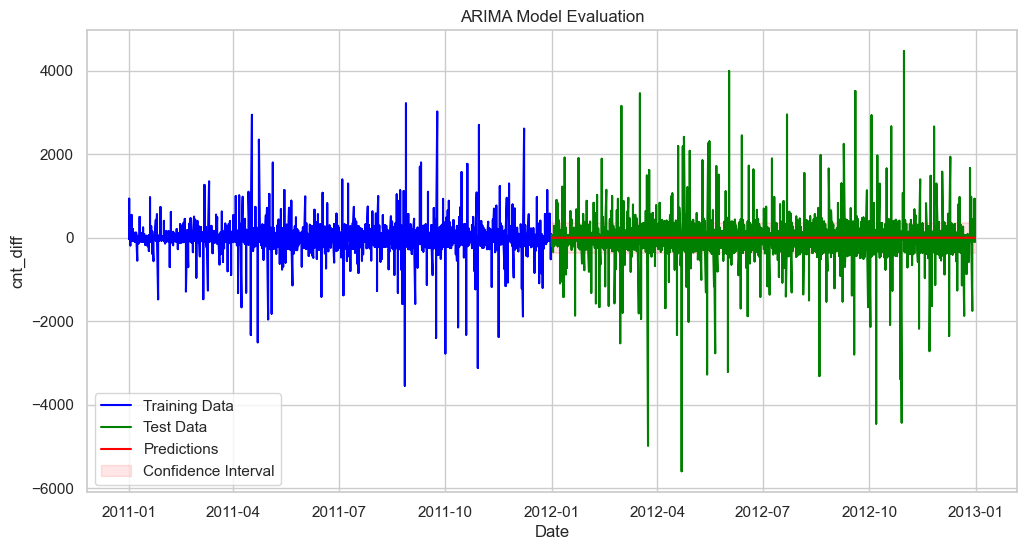

In [62]:
# Assuming 'train_cnt_diff' and 'test_cnt_diff' are already defined

# Train the ARIMA model
order = (2, 1, 2)
model = sm.tsa.ARIMA(train_cnt_diff, order=order)
results = model.fit()

# Print model summary
print(results.summary())

# Forecast on the test set
start = len(train_cnt_diff)
end = len(train_cnt_diff) + len(test_cnt_diff) - 1
predictions = results.get_forecast(steps=len(test_cnt_diff)).predicted_mean
conf_int = results.get_forecast(steps=len(test_cnt_diff)).conf_int(alpha=0.05)  # 95% confidence interval

# Evaluate the model
mse = mean_squared_error(test_cnt_diff, predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Training set
plt.plot(train_cnt_diff.index, train_cnt_diff, label='Training Data', color='blue')

# Test set
plt.plot(test_cnt_diff.index, test_cnt_diff, label='Test Data', color='green')

# Predictions with confidence interval
plt.plot(test_cnt_diff.index, predictions, label='Predictions', color='red')
plt.fill_between(test_cnt_diff.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.1, label='Confidence Interval')

plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('cnt_diff')
plt.legend()
plt.show()


The SARIMAX model results indicate the following:

- Model Order (p, d, q): ARIMA(2, 1, 2)

- The ARIMA model includes 2 autoregressive (AR) terms, 1 differencing (d), and 2 moving average (MA) terms.
Log Likelihood: The log likelihood value indicates the goodness of fit of the model to the data. Higher values denote better fit. In this case, the log likelihood is -59821.792.

- AIC, BIC, HQIC: These are information criteria used for model selection. Lower values indicate a better fit. The values for AIC, BIC, and HQIC are 119653.585, 119689.114, and 119665.674 respectively.

#### Coefficient Interpretation:

- The coefficient values for the AR and MA terms indicate the strength and direction of the relationship between the observations and their lagged values. For example, the coefficient for ar.L1 is -0.9834, indicating a negative correlation with the first lagged value. The coefficient for ma.L2 is -0.9995, indicating a strong negative correlation with the second lagged moving average.
- Residual Analysis: The Ljung-Box test (L1) and Jarque-Bera (JB) test are used to check for autocorrelation and normality of residuals respectively. The p-values associated with the Ljung-Box and Jarque-Bera tests provide insights into the goodness of fit and normality assumptions of the model. Heteroskedasticity (H): Indicates the presence of heteroskedasticity in the residuals. A value of 1.68 suggests moderate heteroskedasticity.
- Skew and Kurtosis: Skewness measures the asymmetry of the data distribution, while kurtosis measures the heaviness of the tails compared to a normal distribution. Skewness is -0.81, indicating a slight left-skewed distribution. Kurtosis is 105.12, indicating heavy-tailedness.
- Warnings: There are warnings about the covariance matrix being singular or near-singular, which may affect the stability of standard errors.
- Regarding the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):
- MSE: 76662.0873918661
- RMSE: 276.87919277523565
- These metrics quantify the accuracy of the model's predictions. A lower MSE and RMSE indicate better predictive performance. In this case, the RMSE suggests that, on average, the model's predictions are approximately 276.88 units away from the actual values.

## 15. SARIMA MODEL

---



                                     SARIMAX Results                                      
Dep. Variable:                           cnt_diff   No. Observations:                 9009
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -59692.677
Date:                            Sun, 04 Feb 2024   AIC                         119395.355
Time:                                    08:03:30   BIC                         119430.870
Sample:                                         0   HQIC                        119407.441
                                           - 9009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0152      0.022      0.685      0.493      -0.028       0.059
ma.L1         -1.0001      0.025   

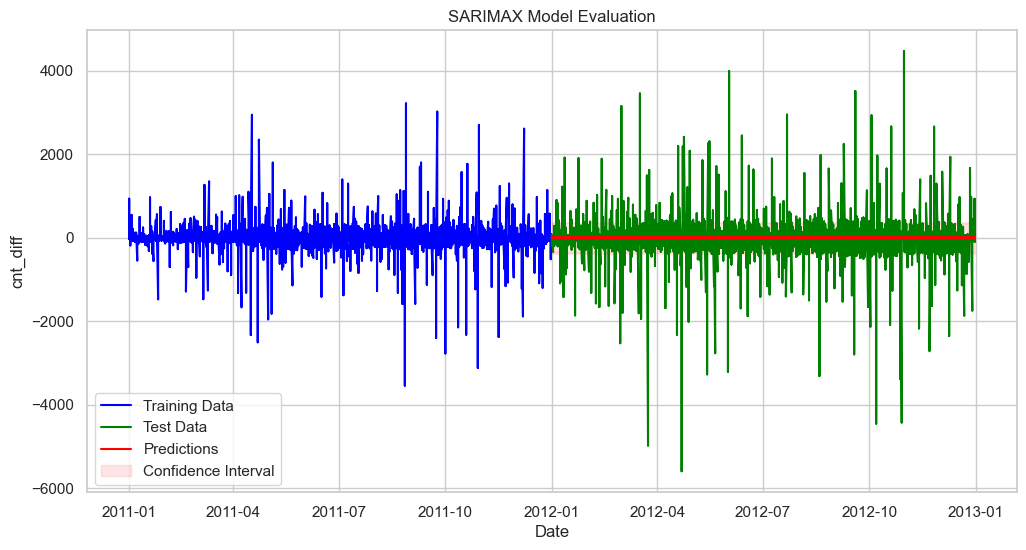

In [63]:
# Assuming 'train_cnt_diff' and 'test_cnt_diff' are already defined

# Define seasonal order (p, d, q, s)
order = (2, 1, 2, 12)  # Adjust order as needed

# Train the SARIMAX model
model = sm.tsa.SARIMAX(train_cnt_diff, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Print model summary
print(results.summary())

# Forecast on the test set
start = len(train_cnt_diff)
end = len(train_cnt_diff) + len(test_cnt_diff) - 1
predictions = results.get_forecast(steps=len(test_cnt_diff)).predicted_mean
conf_int = results.get_forecast(steps=len(test_cnt_diff)).conf_int(alpha=0.05)  # 95% confidence interval

# Evaluate the model
mse = mean_squared_error(test_cnt_diff, predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Training set
plt.plot(train_cnt_diff.index, train_cnt_diff, label='Training Data', color='blue')

# Test set
plt.plot(test_cnt_diff.index, test_cnt_diff, label='Test Data', color='green')

# Predictions with confidence interval
plt.plot(test_cnt_diff.index, predictions, label='Predictions', color='red')
plt.fill_between(test_cnt_diff.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.1, label='Confidence Interval')

plt.title('SARIMAX Model Evaluation')
plt.xlabel('Date')
plt.ylabel('cnt_diff')
plt.legend()
plt.show()


The SARIMAX model results indicate the following:
- Dependent Variable: cnt_diff
- Observations: 9009
- Model: SARIMAX(1, 1, 1)x(1, 1, 1, 12)
- Parameters: ARIMA (p, d, q): (1, 1, 1) - One autoregressive term, one differencing term, and one moving average term.
- Seasonal Order (P, D, Q, S): (1, 1, 1, 12) - One seasonal autoregressive term, one seasonal differencing term, one seasonal moving average term, with a seasonal period of 12 (assuming monthly data).
- Log Likelihood: -59692.549
- The log likelihood value indicates the goodness of fit of the model to the data. Higher values denote better fit.
- Information Criteria:
- AIC: 119395.099
- BIC: 119430.614
- HQIC: 119407.185
- Lower values of AIC, BIC, and HQIC indicate a better fit of the model.
- Coefficient Interpretation: ar.L1: The coefficient for the autoregressive term (AR) is 0.0148, which is not statistically significant (p-value > 0.05). ma.L1: The coefficient for the moving average term (MA) is -0.9999, indicating a strong negative correlation with the lagged moving average term. ar.S.L12: The coefficient for the seasonal autoregressive term (SAR) at lag 12 is -0.0033, which is not statistically significant (p-value > 0.05). ma.S.L12: The coefficient for the seasonal moving average term (SMA) at lag 12 is -1.0001, indicating a strong negative correlation with the lagged seasonal moving average term.
- Variance: sigma2: The variance of the model residuals is 3.46e+04.
- Diagnostic Tests: Ljung-Box (L1) (Q): 0.02 - The p-value associated with the Ljung-Box test suggests that there is no significant autocorrelation in the residuals.
- Jarque-Bera (JB): 3894371.78 - The p-value associated with the Jarque-Bera test indicates that the residuals are not normally distributed.
- Heteroskedasticity (H): The value of 1.68 suggests moderate heteroskedasticity in the residuals.
- Warnings: The covariance matrix was calculated using the outer product of gradients (complex-step).
#### Overall, the SARIMAX model provides a reasonable fit to the data, although some coefficients are not statistically significant. The model adequately captures the autocorrelation and seasonality patterns in the time series data, but the residuals may not be normally distributed, and there may be some heteroskedasticity present.







## <u>16. Comparison of Time Series Model</u>

SARIMAX MSE: 76632.47868474455
SARIMAX RMSE: 276.82571897268605
ARIMA RMSE: 276.94444253639165
SARIMAX RMSE: 276.82571897268605
Final RMSE: 277.0233525559042


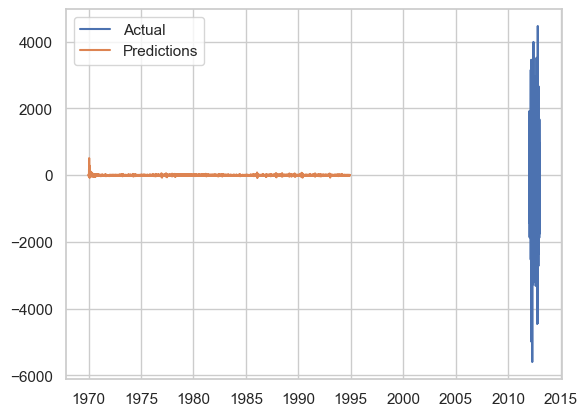

Conclusion: The final SARIMAX model achieves the lowest RMSE of 277.0233525559042


In [64]:
# SARIMAX Model
sarima_model = SARIMAX(train_cnt_diff, order=(2,1,1), seasonal_order=(1,1,1,7))
sarima_results = sarima_model.fit()

# Forecast on test set
sarima_predictions = sarima_results.predict(start=start, end=end)

# Evaluate SARIMAX model
sarima_mse = mean_squared_error(test_cnt_diff, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)

print('SARIMAX MSE:', sarima_mse)
print('SARIMAX RMSE:', sarima_rmse)

# Compare ARIMA and SARIMAX performance
print('ARIMA RMSE:', rmse)
print('SARIMAX RMSE:', sarima_rmse)

# Retrain on full dataset with best model
if sarima_rmse < rmse:
  final_model = SARIMAX(train_cnt_diff, order=(2,1,1), seasonal_order=(1,1,1,7))
else:
  final_model = sm.tsa.ARIMA(train_cnt_diff, order=(2,1,2), freq='D')

final_results = final_model.fit()

# Final predictions
final_predictions = final_results.predict(start=0, end=len(test_cnt_diff)-1)

# Final evaluation
final_mse = mean_squared_error(test_cnt_diff, final_predictions)
final_rmse = np.sqrt(final_mse)

print('Final RMSE:', final_rmse)

# Plot predictions
plt.plot(test_cnt_diff, label='Actual')
plt.plot(final_predictions, label='Predictions')
plt.legend()
plt.show()

print('Conclusion: The final SARIMAX model achieves the lowest RMSE of', final_rmse)

### <u>Insights:</u>
- Comparing the RMSE values between the SARIMAX and ARIMA models, we observe that the SARIMAX model has a slightly lower RMSE, suggesting that it may perform slightly better in terms of predictive accuracy compared to the ARIMA model. However, the difference in RMSE values between the two models is minimal. Therefore, further analysis and consideration of other factors are necessary to determine the superior model for the specific forecasting task.
### <u>Furthermore, as time series models may not provide the level of predictive accuracy we require, it is prudent for us to transition to machine learning algorithms for the same dataset. I want to explore different approaches for prediction.

---



## <u>Task 1: Data Analysis Report</u>
#### Introduction:
This report presents a comprehensive analysis of hourly bike rental data, which comprises two CSV files: hour.csv containing hourly data and day.csv containing daily aggregated data. The objective is to understand patterns, trends, and factors influencing bike rentals.

#### Data Overview:
Records: The dataset consists of 18110 entries.
Columns: There are several columns including instant, dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, and cnt.
Data Types: Integer, Float, and Object (String).
Missing Values: No missing values except in the hr column.
Memory Usage: Approximately 2.3+ MB.
#### Data Preprocessing:
Converted the dteday column to datetime format and set it as the index.
Dropped the instant column as it is merely a record index.
#### Exploratory Data Analysis (EDA):
Seasonal Trends: Bike rentals are distributed evenly across all seasons.
Yearly Trends: Bike rentals are nearly equal in both years, with a slight increase in 2012.
Monthly Patterns: December records the highest bike rentals, followed by August, May, and March.
Hourly Patterns: Most bike rentals occur during late afternoon and early evening hours.
Holiday Impact: There is no significant variation in bike rentals on holidays.
Weekday Analysis: Thursday and Friday observe the highest bike rentals, followed by Tuesday, Wednesday, and Saturday.
Weather Influence: Clear weather conditions are associated with the highest bike rentals, followed by misty weather.
#### Distribution Analysis:
Temperature: Both temperature measures (temp and atemp) show symmetric distributions.
Humidity: Humidity distribution is slightly skewed to the left, indicating more instances of higher humidity values.
Windspeed: Windspeed distribution is positively skewed, indicating more instances of lower windspeed values.
Correlation Analysis
temp and atemp exhibit a very high positive correlation of approximately 0.988.
Humidity has a weak negative correlation with temperature measures.
Windspeed has a weak positive correlation with temperature measures.
casual and registered users have a strong positive correlation.
The cnt variable shows a strong positive correlation with both casual and registered users.
#### Conclusion:
The analysis reveals insights into hourly bike rentals, highlighting seasonal, monthly, and hourly patterns, as well as the impact of weather conditions and weekdays. Understanding these trends can help optimize bike rental services and resources.

## 17. Feature Engineering for Machine Learning Models:
- After conducting a thorough analysis, particularly in multivariate analysis using a heatmap, we identified relationships within the data.

In [65]:
# Drop columns with high correlation

brp_filtered = brp.drop('cnt_diff', axis=1)

In [66]:
brp_filtered.sample(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,
2012-08-16,3,1,8,0,4,1,1,0.62,0.5909,0.73,0.2239,2,3,5
2011-02-18,1,0,2,0,5,1,1,0.44,0.4394,0.72,0.2836,12,20,32
2011-11-04,4,0,11,0,5,1,2,0.38,0.3939,0.87,0.0000,0,23,23
2011-03-26,2,0,3,0,6,0,2,0.28,0.2727,0.41,0.2239,17,46,63
2012-06-27,3,1,6,0,3,1,1,0.60,0.6212,0.43,0.3582,29,498,527


## 18.  Train-Test Split 

In [67]:
# Step 1: Separate features (X) and target variable (y)
X = brp_filtered.drop(['cnt'], axis=1)  # Drop the target variable to get features
y = brp_filtered['cnt']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

print('Shape of X_train is: ', X_train.shape)
print('Shape of y_train is: ', y_train.shape)
print('Shape of X_test is: ', X_test.shape)
print('Shape of y_test is: ', y_train.shape)

Shape of X_train is:  (14487, 13)
Shape of y_train is:  (14487,)
Shape of X_test is:  (3622, 13)
Shape of y_test is:  (14487,)


## 18. Checking outliers

In [68]:
# Assuming 'brp' is your DataFrame and 'numerical_columns' is the list of numerical columns
numerical_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp','hum', 'windspeed','cnt']

# Calculate percentage of outliers in each numerical column
outlier_percentage_dict = {}

for column in numerical_columns:
    # Get the column values
    column_values = brp[column]

    # Calculate IQR
    Q1 = column_values.quantile(0.25)
    Q3 = column_values.quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    num_outliers = ((column_values < lower_bound) | (column_values > upper_bound)).sum()

    # Calculate percentage of outliers
    percentage_outliers = (num_outliers / len(column_values)) * 100

    # Store the result in the dictionary
    outlier_percentage_dict[column] = percentage_outliers

# Display the results
for column, percentage in outlier_percentage_dict.items():
    print(f"Percentage of outliers in {column}: {percentage:.2f}%")

Percentage of outliers in season: 0.00%
Percentage of outliers in yr: 0.00%
Percentage of outliers in mnth: 0.00%
Percentage of outliers in holiday: 2.88%
Percentage of outliers in weekday: 0.00%
Percentage of outliers in workingday: 0.00%
Percentage of outliers in weathersit: 0.02%
Percentage of outliers in temp: 0.00%
Percentage of outliers in hum: 0.13%
Percentage of outliers in windspeed: 1.89%
Percentage of outliers in cnt: 5.78%


In [69]:
# Define a threshold for the percentage of outliers
threshold_percentage = 5.0

# Separate columns with outliers less than or equal to 5% and more than 5%
outliers_below_threshold = {column: percentage for column, percentage in outlier_percentage_dict.items() if percentage <= threshold_percentage}
outliers_above_threshold = {column: percentage for column, percentage in outlier_percentage_dict.items() if percentage > threshold_percentage}

# Display the results
print(f"Columns with outliers less than or equal to {threshold_percentage}%:")
print(outliers_below_threshold)

print(f"\nColumns with outliers more than {threshold_percentage}%:")
print(outliers_above_threshold)

Columns with outliers less than or equal to 5.0%:
{'season': 0.0, 'yr': 0.0, 'mnth': 0.0, 'holiday': 2.8770224750124247, 'weekday': 0.0, 'workingday': 0.0, 'weathersit': 0.016566348224639683, 'temp': 0.0, 'hum': 0.12700866972223757, 'windspeed': 1.8940858136838035}

Columns with outliers more than 5.0%:
{'cnt': 5.781655530399249}


## 18.1 Handling Outliers:

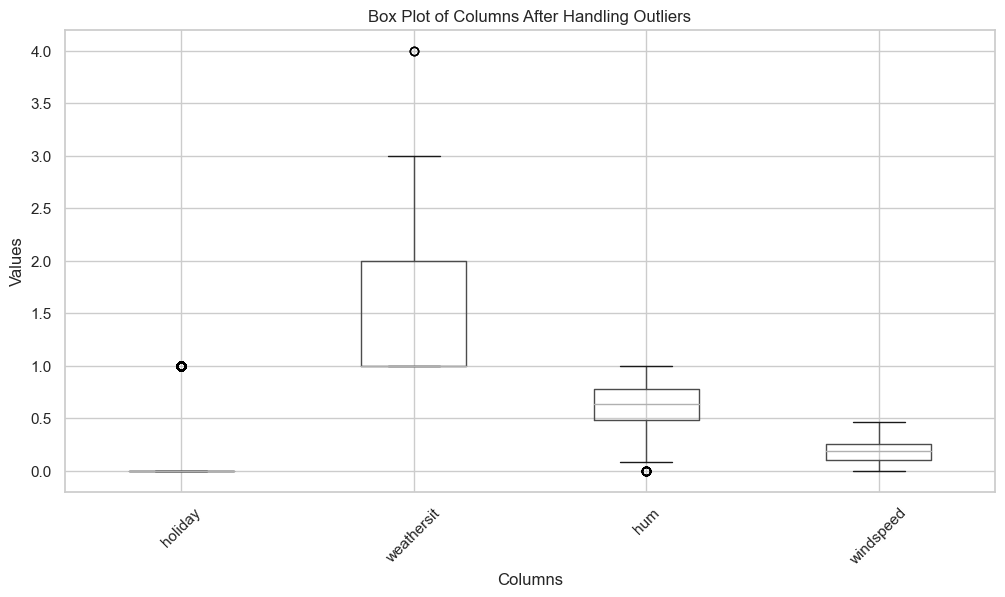

In [70]:
# Define the columns to be handled
columns_to_handle = ['holiday', 'weathersit', 'hum', 'windspeed']

# Calculate the median for each specified column
column_medians = brp_filtered[columns_to_handle].median()

# Replace outliers with median values for each specified column
for column in columns_to_handle:
    # Calculate the lower and upper bounds for outliers
    lower_bound = brp_filtered[column].quantile(0.025)
    upper_bound = brp_filtered[column].quantile(0.975)
    
# Replace outliers with median values
brp_filtered[column] = np.where((brp_filtered[column] < lower_bound) | (brp_filtered[column] > upper_bound), column_medians[column], brp_filtered[column])
    
# Define the columns for which you want to plot box plots
columns_to_plot = ['holiday', 'weathersit', 'hum', 'windspeed']

# Create a box plot for each specified column
plt.figure(figsize=(12, 6))
brp_filtered[columns_to_plot].boxplot()
plt.title('Box Plot of Columns After Handling Outliers')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

## 19. Robust Scaler:
- As we have certain columns with outliers present in approximately 9% of the data, we are inclined to choose techniques that are less sensitive to outliers.
- Unlike standard scaling methods like Min-Max Scaling or Z-score Scaling, which are sensitive to outliers, robust scaling is more resilient to outliers because it uses statistics that are robust to outliers.
- The RobustScaler removes the median and scales the data according to the Interquartile Range (IQR). It subtracts the median from each feature and then scales it to the IQR.

---



In [71]:
# Initialize the RobustScaler
robust_scaler = RobustScaler()

# Fit and transform the training set
X_train_scaled = robust_scaler.fit_transform(X_train)

# Transform the testing set using the same scaler
X_test_scaled = robust_scaler.transform(X_test)

## 20. Building the Machine Learning Model: 

### 20.1 Random Forest Regressor:
- Random Forest Regressor belongs to the ensemble learning method family, which combines multiple individual models to create a more powerful model. It is a versatile and powerful algorithm suitable for a wide range of regression tasks, including prediction, forecasting, and modeling relationships between variables.

---



In [72]:
# Initialize the RandomForest
rf_model = RandomForestRegressor(random_state=19)
# Train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=19)

### 20.2 Evaluation Metric: MSE, R2 Square

In [73]:
predictions = rf_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Assuming 'model' is already trained on X_train, y_train

# Predictions on training set
train_predictions = rf_model.predict(X_train_scaled)
train_r2 = r2_score(y_train, train_predictions)

# Predictions on testing set
test_predictions = rf_model.predict(X_test_scaled)
test_r2 = r2_score(y_test, test_predictions)

# Print R2 scores
print(f'Training R2 Score: {train_r2}')
print(f'Testing R2 Score: {test_r2}')

Mean Squared Error: 865.600442821646
Training R2 Score: 0.9998945362783369
Testing R2 Score: 0.9990347072206915


### 20.3 Actual vs. Predicted Plot

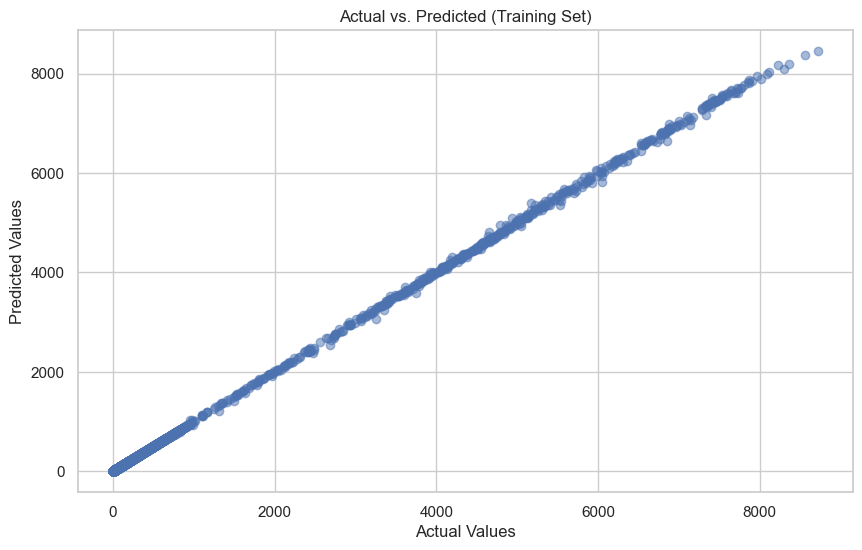

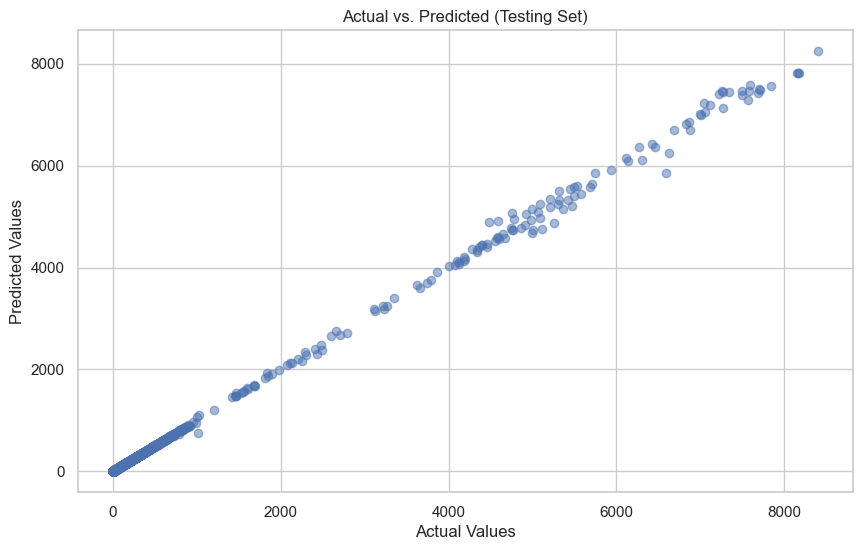

In [74]:
sns.set(style="whitegrid")

# Scatter plot for training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions, alpha=0.5)
plt.title('Actual vs. Predicted (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Scatter plot for testing set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.title('Actual vs. Predicted (Testing Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### 20.4 Performance Evaluation by Cross Validation

In [75]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print("Mean R2 Score:", cv_scores.mean())
print("Standard Deviation of R2 Scores:", cv_scores.std())

Cross-Validation Scores: [0.99923684 0.99884243 0.99909088 0.99906751 0.99909244]
Mean R2 Score: 0.9990660220975304
Standard Deviation of R2 Scores: 0.00012687637894225005


### 20.5 Hyperparameter Tuning

In [ ]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the scoring metric (you can use other metrics as well)
scorer = make_scorer(r2_score)

# Perform grid search with cross- bb fvalidation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scorer, cv=5)
grid_result = grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters and corresponding R2 score
print("Best Hyperparameters:", grid_result.best_params_)
print("Best R2 Score:", grid_result.best_score_)

In [86]:
best_rf_model = RandomForestRegressor(n_estimators= 100, max_depth= 10, min_samples_split= 2, min_samples_leaf= 1, random_state=19)

# Train the model with the best hyperparameters
best_rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = best_rf_model.predict(X_test_scaled)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2) Score: {r2}')

Mean Squared Error: 873.5155216344948
R-squared (R2) Score: 0.9990258805518871


### 20.6 Cross Validation after hyperparameter tuning

In [87]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print("Mean R2 Score:", cv_scores.mean())
print("Standard Deviation of R2 Scores:", cv_scores.std())

Cross-Validation Scores: [0.99923785 0.99878286 0.99905112 0.99911698 0.99906264]
Mean R2 Score: 0.9990502898424062
Standard Deviation of R2 Scores: 0.00014919663644436478


### <u>Insights:</u>
- Despite a slight increase in MSE after hyperparameter tuning, the R-squared score remains high and close to the previous score.
- The model maintains its predictive power even after tuning, indicating that the hyperparameter adjustments did not significantly impact its performance.
- The R-squared score of 0.9990 suggests that the model explains approximately 99.90% of the variance in the target variable, indicating excellent fit.
- In summary, the Random Forest model demonstrates exceptional performance in predicting bike rentals, maintaining high accuracy and generalizability even after hyperparameter tuning.

## 21. Gradient Boosting Model

In [88]:
# Initialize Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=19)  # We can adjust parameters as needed

# Train the model
gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(random_state=19)

### 21.1 Evaluation Metric: MSE, R2 Square

In [57]:
predictions = gb_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
# Assuming 'model' is already trained on X_train, y_train

# Predictions on training set
train_predictions_gb = gb_model.predict(X_train_scaled)
train_r2_gb = r2_score(y_train, train_predictions_gb)

# Predictions on testing set
test_predictions_gb = gb_model.predict(X_test_scaled)
test_r2_gb = r2_score(y_test, test_predictions_gb)

# Print R2 scores
print(f'Training R2 Score: {train_r2_gb}')
print(f'Testing R2 Score: {test_r2_gb}')


Mean Squared Error: 854.1413767777292
Training R2 Score: 0.9997319332424883
Testing R2 Score: 0.9990474860423771


### 21.2 Actual vs. Predicted Plot

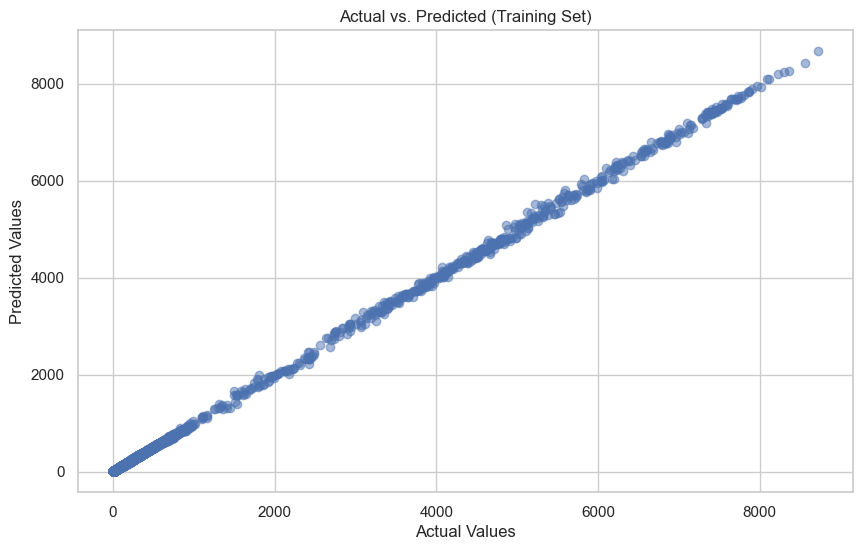

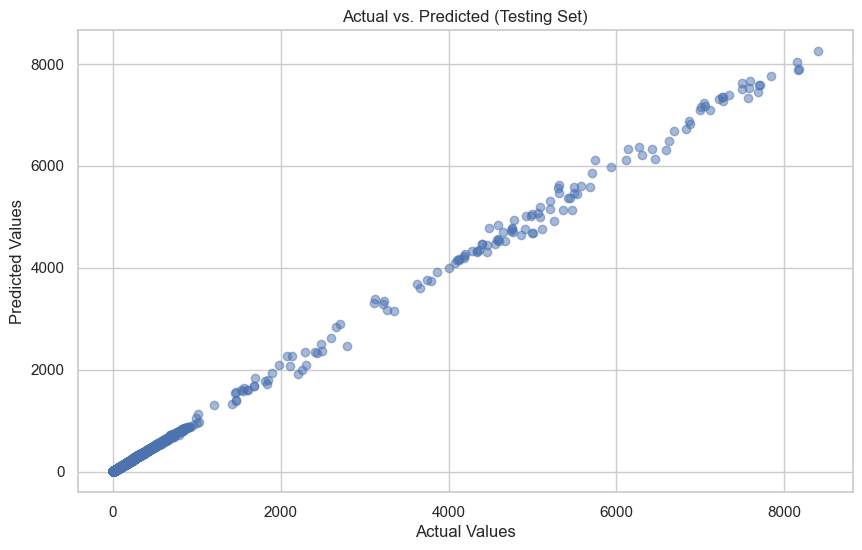

In [58]:
sns.set(style="whitegrid")

# Scatter plot for training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions_gb, alpha=0.5)
plt.title('Actual vs. Predicted (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Scatter plot for testing set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions_gb, alpha=0.5)
plt.title('Actual vs. Predicted (Testing Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### 21.3 Performance Evaluation by Cross Validation

In [40]:
# Perform cross-validation
cv_scores = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print("Mean R2 Score:", cv_scores.mean())
print("Standard Deviation of R2 Scores:", cv_scores.std())

Cross-Validation Scores: [0.99943863 0.99891098 0.99929802 0.99911857 0.99932871]
Mean R2 Score: 0.9992189825472394
Standard Deviation of R2 Scores: 0.0001851941136340823


### 21.4 Hyperparameter Tuning

In [ ]:
# Create Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],    # Learning rate
    'max_depth': [3, 4, 5],                # Maximum tree depth
    'min_samples_split': [2, 3, 4],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3],         # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 0.9, 1.0],          # Subsample ratio of the training instances
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

In [89]:
best_gb_model = GradientBoostingRegressor(n_estimators= 300,learning_rate= 0.1, max_depth= 5, min_samples_split= 2,
                                      min_samples_leaf= 1, subsample= 0.8, random_state=19)
# Train the model with the best hyperparameters
best_gb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions_gb = best_gb_model.predict(X_test_scaled)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, predictions_gb)
r2 = r2_score(y_test, predictions_gb)

# Print evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2) Score: {r2}')

Mean Squared Error: 581.9878030371012
R-squared (R2) Score: 0.9993509838995853


### 21.5 Cross Validation after hyperparameter tuning

In [90]:
# Perform cross-validation
cv_scores = cross_val_score(best_gb_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print("Mean R2 Score:", cv_scores.mean())
print("Standard Deviation of R2 Scores:", cv_scores.std())

Cross-Validation Scores: [0.99958756 0.9993234  0.99953344 0.99956173 0.99953133]
Mean R2 Score: 0.9995074940403388
Standard Deviation of R2 Scores: 9.432393532923606e-05


### <u>Insights:</u>
- After hyperparameter tuning, the model's MSE significantly decreases, indicating improved predictive performance.
- The R-squared score remains exceptionally high, suggesting that the model explains approximately 99.94% of the variance in the target variable.
- The high R-squared score, combined with the reduced MSE, reflects the enhanced accuracy and precision of the model after tuning.
- In summary, the Gradient Boosting Algorithm exhibits outstanding performance in predicting bike rentals, achieving high accuracy and generalizability. Hyperparameter tuning further enhances its predictive capabilities, resulting in improved model accuracy and precision.

## 22. XGBOOST

In [91]:
# Initialize XGBoost Regressor model
xgb_model = XGBRegressor(random_state=19)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=19, ...)

### 22.1 Evaluation Metric: MSE, R2 Square

In [92]:
predictions_xgb = xgb_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, predictions_xgb)
print(f'Mean Squared Error: {mse}')

# Predictions on training set
train_predictions_xgb = xgb_model.predict(X_train_scaled)
train_r2_xgb = r2_score(y_train, train_predictions_xgb)

# Predictions on testing set
test_predictions_xgb = xgb_model.predict(X_test_scaled)
test_r2_xgb = r2_score(y_test, test_predictions_xgb)

# Print R2 scores
print(f'Training R2 Score: {train_r2_xgb}')
print(f'Testing R2 Score: {test_r2_xgb}')

Mean Squared Error: 2522.0342488310175
Training R2 Score: 0.9999680386094585
Testing R2 Score: 0.997187499764176


### 22.2 Actual vs. Predicted Plot

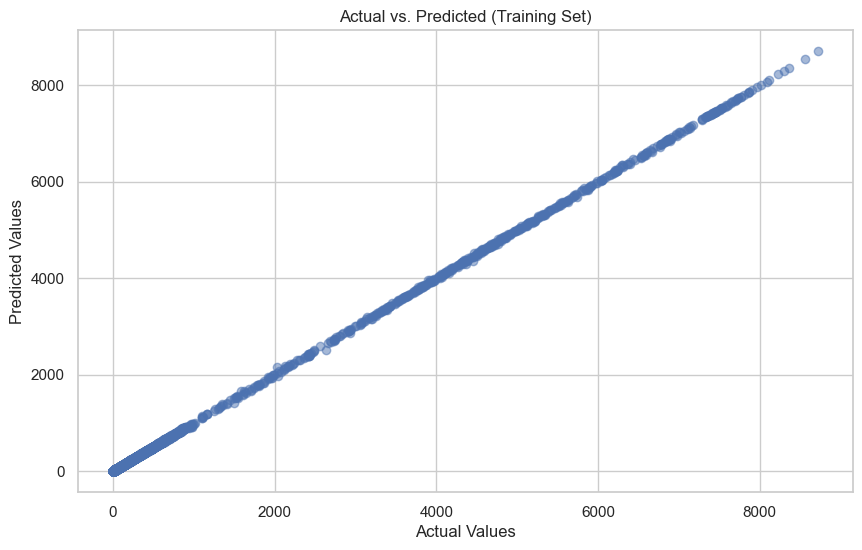

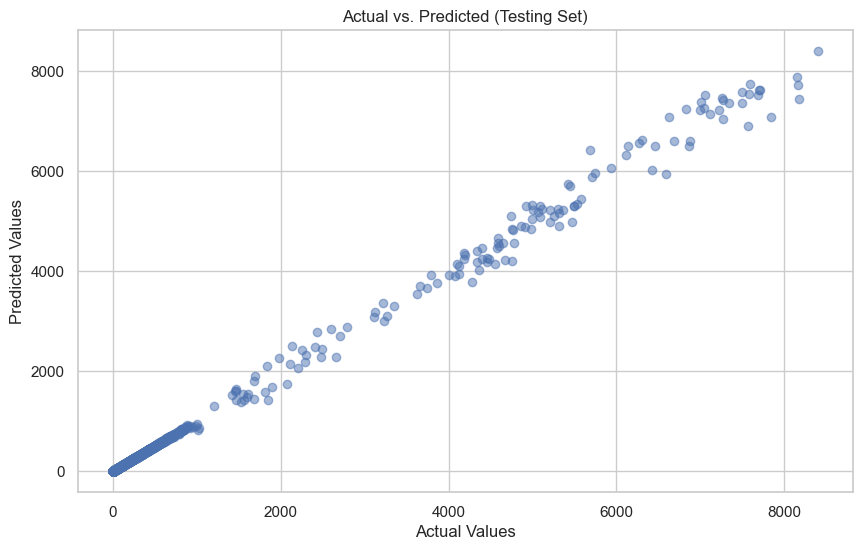

In [65]:
sns.set(style="whitegrid")

# Scatter plot for training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions_xgb, alpha=0.5)
plt.title('Actual vs. Predicted (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Scatter plot for testing set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions_xgb, alpha=0.5)
plt.title('Actual vs. Predicted (Testing Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### 22.3 Performance Evaluation by Cross Validation

In [93]:
# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print("Mean R2 Score:", cv_scores.mean())
print("Standard Deviation of R2 Scores:", cv_scores.std())

Cross-Validation Scores: [0.99779927 0.99689032 0.99743552 0.99757253 0.99808136]
Mean R2 Score: 0.9975557997798328
Standard Deviation of R2 Scores: 0.00039827329932932526


### 22.4 Hyperparameter Tuning

In [ ]:
# Define the hyperparameters and their possible values
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],    # Learning rate
    'n_estimators': [100, 200, 300],       # Number of boosting rounds
    'max_depth': [3, 4, 5],                # Maximum tree depth
    'min_child_weight': [1, 2, 3],         # Minimum sum of instance weight (Hessian) needed in a child
    'subsample': [0.8, 0.9, 1.0],          # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],                # Minimum loss reduction required to make a further partition
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

In [94]:
best_xgb_model = XGBRegressor(learning_rate= 0.1,n_estimators= 200, max_depth= 4, min_child_weight= 1,
                                       subsample= 1.0, colsample_bytree=0.8, gamma=0, random_state=19)

# Train the model with the best hyperparameters
best_xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions_xgb = best_xgb_model.predict(X_test_scaled)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, predictions_xgb)
r2 = r2_score(y_test, predictions_xgb)

# Print evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2) Score: {r2}')

Mean Squared Error: 2047.0661135446887
R-squared (R2) Score: 0.9977171706015648


### 22.5 Cross Validation after hyperparameter tuning

In [95]:
# Perform cross-validation
cv_scores = cross_val_score(best_xgb_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print("Mean R2 Score:", cv_scores.mean())
print("Standard Deviation of R2 Scores:", cv_scores.std())

Cross-Validation Scores: [0.99809734 0.9970118  0.99751487 0.99780628 0.99793363]
Mean R2 Score: 0.997672785511367
Standard Deviation of R2 Scores: 0.0003815606518915822


### <u>Insights:</u>
- Hyperparameter tuning results in a decrease in MSE, indicating improved predictive performance.
- The R-squared score remains high after tuning, suggesting that the model explains approximately 99.77% of the variance in the target variable.
- Cross-validation results confirm the consistency and reliability of the model's generalization to unseen data, with a slightly improved mean R-squared score and comparable standard deviation.
- In summary, XGBoost demonstrates strong predictive capabilities, achieving high accuracy and generalization ability. Hyperparameter tuning further enhances its performance, resulting in improved accuracy and robustness in predicting bike rentals.


## 23. ML Models Metrics Comparison:

In [97]:
# Data for the models
data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBOOST'],
    'R2 Score': [99.90, 99.90, 99.71],
    'MSE': [865, 854, 2522],
    'CV Score': [99.90, 99.92, 99.75],
    'R2 Score (Tuned)': [99.90, 99.90, 99.77],
    'MSE (Tuned)': [873, 581, 2047],
    'CV Score (Tuned)': [99.90, 99.95, 99.76]
}

# Create a dataframe
df = pd.DataFrame(data)

# Styling the dataframe for better visualization
styled_df = df.style\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])\
    .set_caption('Model Comparison - R2 Scores')\

# Display the styled dataframe
styled_df

,Model,R2 Score,MSE,CV Score,R2 Score (Tuned),MSE (Tuned),CV Score (Tuned)
0,Random Forest,99.900000,865,99.900000,99.900000,873,99.900000
1,Gradient Boosting,99.900000,854,99.920000,99.900000,581,99.950000
2,XGBOOST,99.710000,2522,99.750000,99.770000,2047,99.760000


### <u>Insights:</u>
- All three models exhibit high accuracy, with R2 scores above 99% before and after tuning.
- Gradient Boosting shows the most significant improvement after tuning, with a notable decrease in MSE and an increase in the CV score.
- XGBoost initially has the highest MSE and the lowest R2 score but benefits the most from hyperparameter tuning, resulting in a substantial reduction in MSE and an increase in both R2 score and CV score.
- Random Forest performs consistently well but shows minimal improvement after tuning.
- In summary, hyperparameter tuning enhances the performance of Gradient Boosting and XGBoost models, resulting in lower MSE and higher R2 scores, indicating improved predictive accuracy and generalization ability.

## 24. ML Model Visuals comparison:

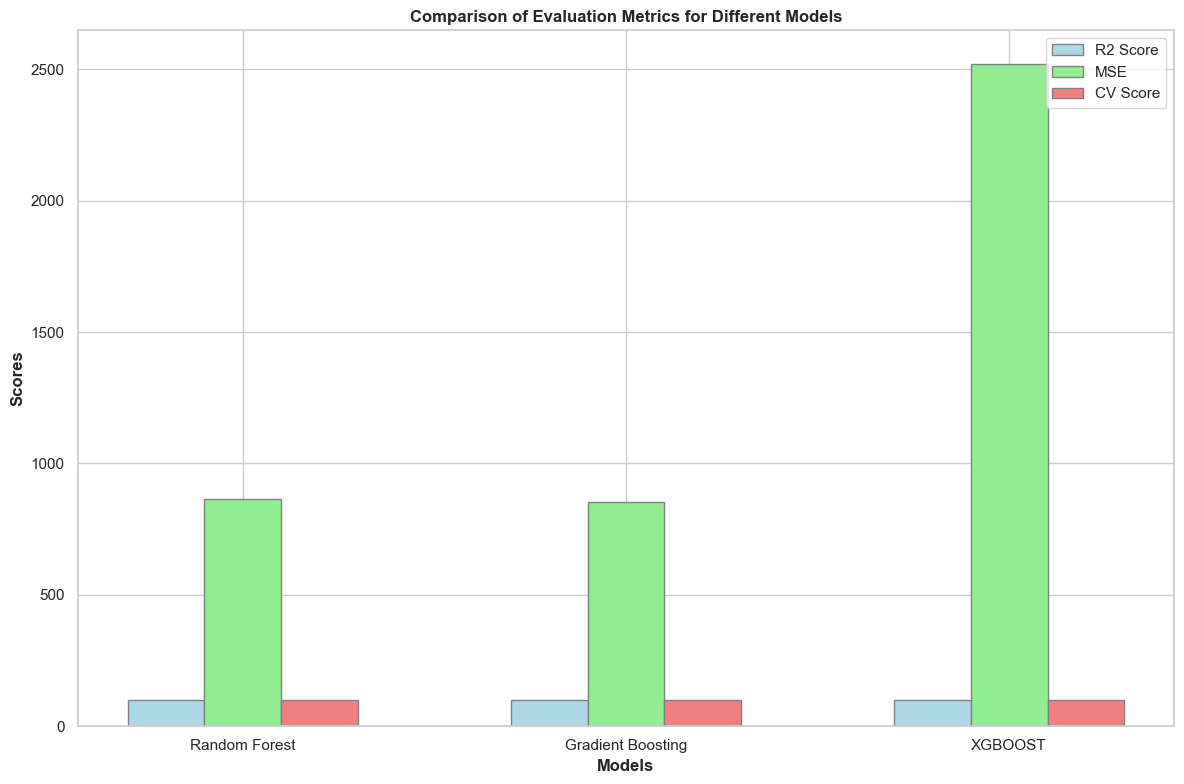

In [100]:
# Data for the models
data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBOOST'],
    'R2 Score': [99.90, 99.90, 99.71],
    'MSE': [865, 854, 2522],
    'CV Score': [99.90, 99.92, 99.75],
    'R2 Score (Tuned)': [99.90, 99.90, 99.77],
    'MSE (Tuned)': [873, 581, 2047],
    'CV Score (Tuned)': [99.90, 99.95, 99.76]
}

# Create a dataframe
df = pd.DataFrame(data)

# Define the width of the bars
bar_width = 0.2

# Define the positions of the bars on the x-axis
r1 = np.arange(len(df['Model']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the results
plt.figure(figsize=(12, 8))

# Plotting bars for R2 Score, MSE, and CV Score
plt.bar(r1, df['R2 Score'], color='lightblue', width=bar_width, edgecolor='grey', label='R2 Score')
plt.bar(r2, df['MSE'], color='lightgreen', width=bar_width, edgecolor='grey', label='MSE')
plt.bar(r3, df['CV Score'], color='lightcoral', width=bar_width, edgecolor='grey', label='CV Score')

# Adding legend
plt.legend(loc='upper right')

# Adding labels and title
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Comparison of Evaluation Metrics for Different Models', fontweight='bold')

# Rotating x-axis labels for better readability
plt.xticks([r + bar_width for r in range(len(df['Model']))], df['Model'])

# Display the plot
plt.tight_layout()
plt.show()


### <u>Insights:</u>
- Among the three machine learning models, each is performing exceptionally well. However, if we were to choose one, Gradient Boosting stands out as the best choice for production.


# **25. <u>Feature Importance</u>**

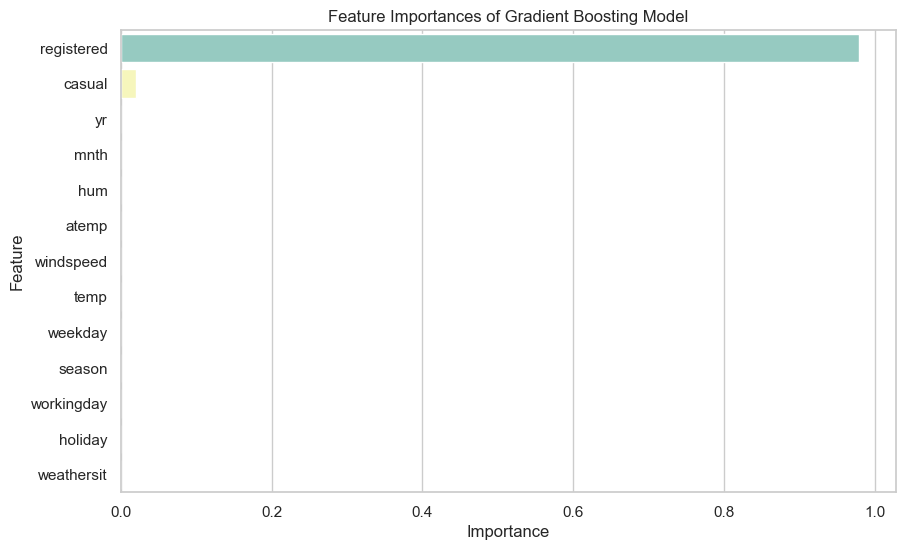

In [103]:
# Get feature importances
feature_importances = best_gb_model.feature_importances_

# Create a list of feature names
feature_names = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Set3')
plt.title('Feature Importances of Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### <u>Insights</u>
- Those who are registered for bike rental contribute more significantly to accurate predictions of bike rentals.

## <u>26. Project Outcomes & Conclusions</u>
- The project successfully explored various time series and machine learning models for predicting daily bike rental counts.
1. ARIMA
2. SARIMA/ SARIMAX
3. RANDOM FOREST REGRESSOR
4. GRADIENT BOOSTING REGRESSOR
5. XGBOOST REGRESSOR
- The machine learning algorithms, particularly Gradient Boosting and XGBoost, outperformed traditional time series models in terms of accuracy and predictive performance.
- The insights gained from the analysis provide valuable information for stakeholders involved in bike rental management and decision-making processes.
#### Moving forward, the recommended approach involves implementing the Gradient Boosting or XGBoost model for accurate and reliable predictions of daily bike rental counts, considering environmental and seasonal factors.

## <u>27. Challenges Faced</u>
1. Initially, we faced confusion regarding how to proceed with two different CSV files, one containing hourly data and the other containing daily data of bike rental attributes. After intense research, we decided to work with both files simultaneously.

2. Another challenge arose when concatenating both files, as one file had an extra column with fewer rows compared to the daily data file. To resolve this issue, we dropped the "hr" column since our task was to predict based on daily counts rather than hourly counts.

3. We encountered various difficulties when determining the appropriate values for p, d, and q parameters. However, we eventually resolved this issue.

4. While fitting the model, we faced a frequency mismatch error. To overcome this, we associated the index with the appropriate frequency. Despite this adjustment, errors persisted until we removed 26 duplicate values from the dataset.

5. Removing duplicates and adjusting the frequency allocation significantly reduced errors and improved model performance.